In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Adapted from: 
# lqr_neural_error_dynamics.ipynb

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

%matplotlib notebook

In [3]:
%matplotlib notebook

In [4]:
#Load a base file for simulation parameters: 
ext_list =['.png', '.eps']

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)
num_cw = 2
cw_label = ['cw', 'ccw']
task_rot_list = [0,1.1,1.2]

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)

#Pre-processing continued:

#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

True
('angle_center:', 22.5)
('min centered angle:', -157.47162455426732)
('max centered angle:', 202.46708261619673)


<IPython.core.display.Javascript object>


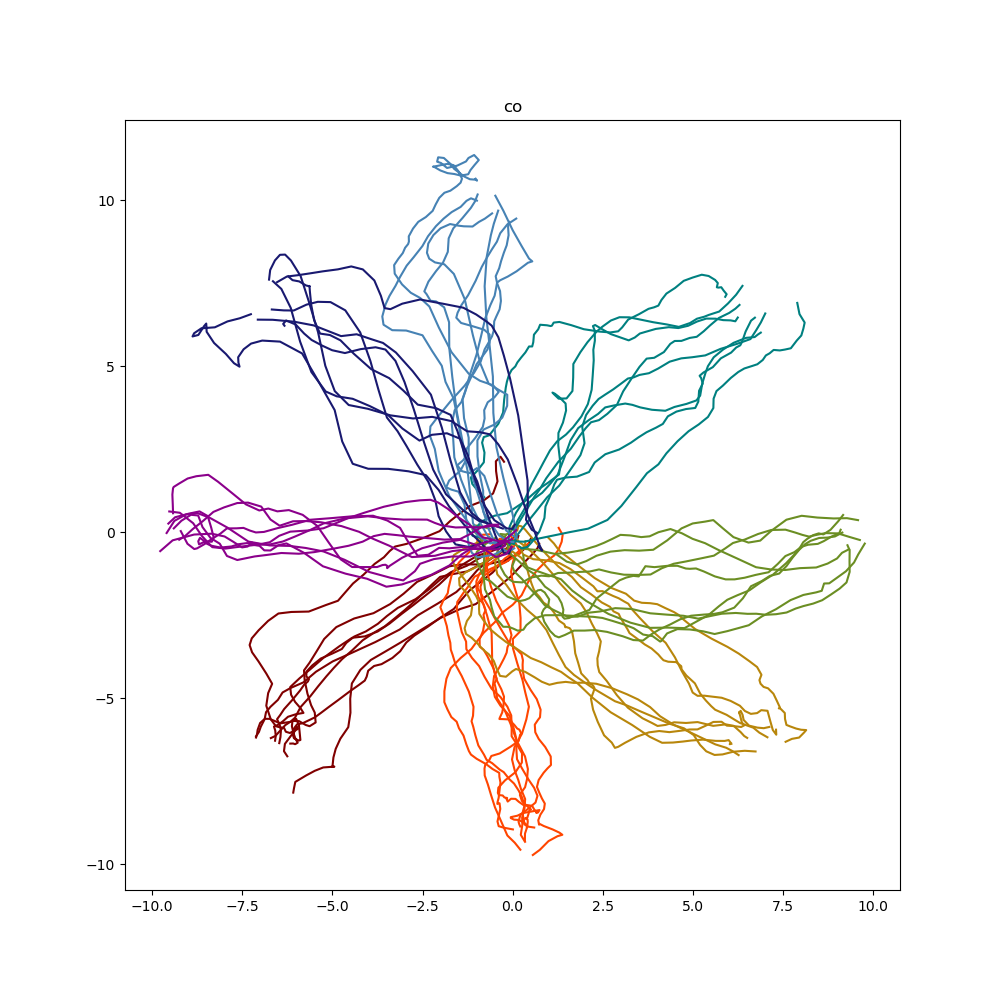

<IPython.core.display.Javascript object>


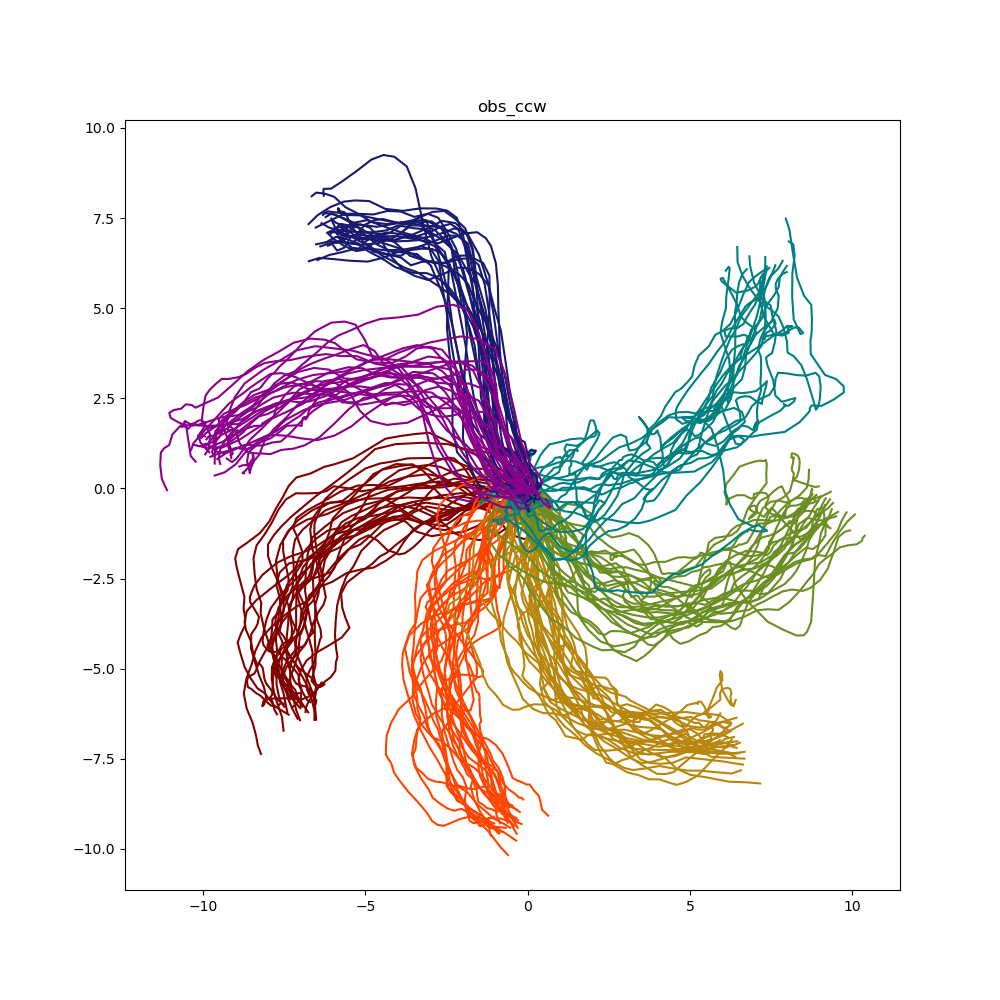

<IPython.core.display.Javascript object>


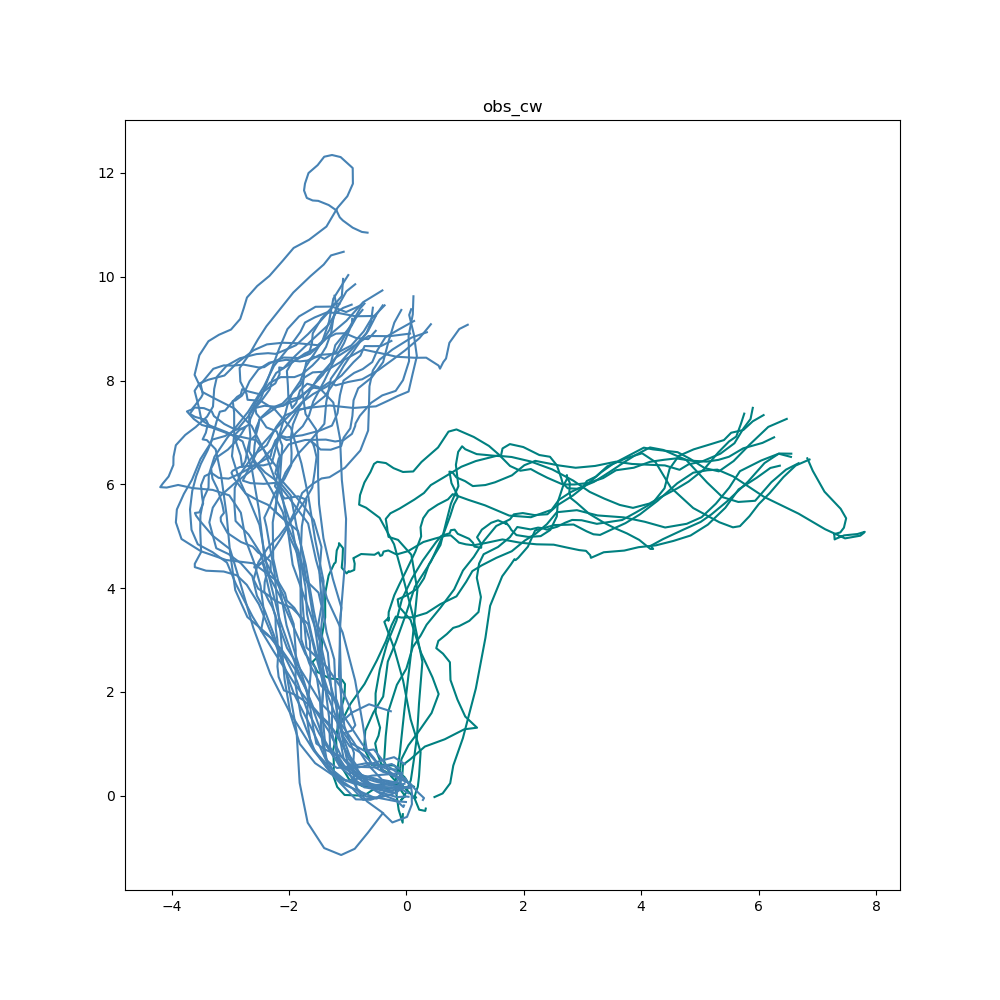

In [5]:
#Plot cw vs ccw trials, to confirm: 
plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

for i,task in enumerate(task_rot_list):
    plt.figure(figsize=plot['size'])
    plt.title(task_rot_label[i])
    for target in range(num_targets):    
            sel = (df['task_rot']==task) & (df['bin']>=0) & (df['target']==target)
            df_sel = df[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.where(df_sel['bin_end']==0)[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)

In [ ]:
#Approach for each file: 
#1) run the noiseless sim, save to its own directory
#2) 

In [6]:
save_home = r'D:\DATA\bmi_co_obs_backup'


dynamics_dir = r'D:\Dropbox\BMI_co_obs_paper\data'
dynamics_path = os.path.join(dynamics_dir, 'dynamics_for_v.pkl')
with open(dynamics_path, 'rb') as f: 
    dynamics_dic = pickle.load(f)

decoder_dir = r'D:\Dropbox\BMI_co_obs_paper\data'
decoder_path = os.path.join(decoder_dir, 'decoders_for_v.pkl')
with open(decoder_path, 'rb') as f: 
    decoder_dic = pickle.load(f)
    
a_list = ['grom', 'jeev']
a2num_days = {'grom':9, 'jeev':4}

# [('jeev', 1, 'F'),
#  ('grom', 5, 'KG'),
#  ('grom', 0, 'KG'),
#  ('grom', 6, 'F'),
#  ('grom', 2, 'KG'),
#  ('grom', 1, 'KG'),
#  ('grom', 4, 'KG'),
#  ('grom', 3, 'KG'),
#  ('grom', 8, 'F'),
#  ('jeev', 1, 'KG'),
#  ('grom', 6, 'KG'),
#  ('grom', 0, 'F'),
#  ('jeev', 0, 'KG'),
#  ('jeev', 2, 'F'),
#  ('grom', 7, 'KG'),
#  ('grom', 8, 'KG'),
#  ('jeev', 3, 'F'),
#  ('grom', 3, 'F'),
#  ('grom', 4, 'F'),
#  ('jeev', 3, 'KG'),
#  ('grom', 1, 'F'),
#  ('jeev', 0, 'F'),
#  ('grom', 5, 'F'),
#  ('grom', 2, 'F'),
#  ('grom', 7, 'F'),
#  ('jeev', 2, 'KG')]

In [55]:
#Parameters: 
#Movement simulation
num_trials = 20
move_horizon = 39
model_list = ['n_do', 'n_null', 'n_o', 'n_d'] #'n_o'
m_noise = 'n_null' #which noiseless simulation to choose to set the noise level

target_list = range(num_targets)
task_rot_list = [0,1.1,1.2]
center = np.array([0,0])
#waypoint parameters:
obs_margin = 6
waypoint_speed = 10

#Cursor Variables: 
kin_var = ['kin_px', 'kin_py', 'kin_vx', 'kin_vy']
num_kin = len(kin_var)
offset_var = ['offset']
num_offset = len(offset_var)

#QR:
Qfp_s = 1e7
Qfv_s = Qfp_s
Qp_s = 0
Qv_s = 0
R_s = 1

In [65]:
move_lqr[0,0,'n_do'].keys()

['A',
 'Q_f',
 'sim_len',
 'B',
 'K_list',
 'move_len',
 'u_da',
 'Q',
 'state_e_da',
 'R',
 'state_T_list',
 'state_init',
 'state_da',
 'horizon_list',
 'A_e_list']

In [62]:
move_lqr[0,0,'n_do']['Q_f']

matrix([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0., 10.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [61]:
move_lqr[0,0,'n_do'].keys()

['A',
 'Q_f',
 'sim_len',
 'B',
 'K_list',
 'move_len',
 'u_da',
 'Q',
 'state_e_da',
 'R',
 'state_T_list',
 'state_init',
 'state_da',
 'horizon_list',
 'A_e_list']

In [60]:
move_lqr[0,0,'n_do']

{'A': matrix([[ 9.86262887e-02,  1.47419371e-02, -1.67200388e-03, ...,
           0.00000000e+00,  0.00000000e+00,  7.10574405e-01],
         [ 6.06758988e-03,  1.48790819e-02,  2.56093566e-04, ...,
           0.00000000e+00,  0.00000000e+00,  3.58345940e-01],
         [-1.08495002e-03, -3.07609095e-03,  5.27076142e-04, ...,
           0.00000000e+00,  0.00000000e+00,  1.36098284e-02],
         ...,
         [ 3.10474437e-02,  5.58690562e-02, -3.37569933e-01, ...,
           5.00000000e-01,  0.00000000e+00,  1.76733291e-01],
         [-6.23252003e-02, -2.02097647e-02, -3.91464545e-01, ...,
           0.00000000e+00,  5.00000000e-01, -1.16183734e-01],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 'A_e_list': [matrix([[ 9.86262887e-02,  1.47419371e-02, -1.67200388e-03, ...,
            0.00000000e+00,  0.00000000e+00,  7.10574405e-01],
          [ 6.06758988e-03,  1.48790819e-02,  2.56093566e-04, ...,
  

In [24]:
a

'jeev'

In [28]:
decoder_dic[(a, 0, 'F')]

array([[ 1.        ,  0.        ,  0.1       ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.1       ,  0.        ],
       [ 0.        ,  0.        ,  0.84072326, -0.30101699, -0.00977625],
       [ 0.        ,  0.        ,  0.10447499,  0.68910572, -0.47380116],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ]])

In [29]:
print(decoder_dic[(a, 0, 'F')].shape)

(5L, 5L)


In [32]:
decoder_dic[(a, 0, 'KG')]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.14534726,  0.32573467,  0.03914972,  0.5998587 ,  0.16853999,
        -0.00899337, -0.14710704, -0.01159171,  0.56797433,  0.74034085,
         0.61764449,  0.45746896,  0.02416892,  0.54927931, -0.17322174,
         0.68909833,  0.10805275,  1.13416715, -0.47493067, -0.25680622],
       [ 0.15045776,  0.02456347, -0.05931557, -0.6561404 , -0.29982217,
        -0.0812002 ,  0.18907891,  0.16688639, -

In [33]:
decoder_dic[(a, 0, 'KG')].shape

(5L, 20L)

In [43]:
type(dynamics_dic[(a,0,'A')])

numpy.ndarray

In [36]:
dynamics_dic[(a,0,'b')].shape

(20L,)

In [8]:
def form_F(F_in): 
    '''
    assumes F_in is of size 5x5, with dimensions in order: 
    kin_px, kin_py, kin_vx, kin_vy, 'offset'
    '''
    
    kin_var = ['kin_px', 'kin_py', 'kin_vx', 'kin_vy']
    num_kin = len(kin_var)
    offset_var = ['offset']
    num_offset = len(offset_var)
    
    F = xr.DataArray(F_in, coords={'out':kin_var+offset_var, 'in':kin_var+offset_var}, dims=['out', 'in'])
    
    return F

In [9]:
def form_K(K_in): 
    '''
    assumes K_in is of size 5xnum_neurons, with dimensions in order: 
    kin_px, kin_py, kin_vx, kin_vy, 'offset'
    '''
    
    kin_var = ['kin_px', 'kin_py', 'kin_vx', 'kin_vy']
    num_kin = len(kin_var)
    offset_var = ['offset']
    num_offset = len(offset_var)
    
    num_neurons = K_in.shape[1]
    n_list = ['n_'+str(i) for i in range(num_neurons)]
    
    K = xr.DataArray(K_in, coords={'out':kin_var+offset_var, 'in':n_list}, dims=['out', 'in'])
    
    return K

In [10]:
def calc_norm_u(move_lqr, task_list, task_rot_list, model_list, noiseless_bool):
    #Collect norm_u results: 
    columns = ['norm_u', 'target', 'task', 'model']
    num_col = len(columns)
    nan_df = pd.DataFrame(np.ones((1,num_col))*np.nan, columns=columns)
    df_list = []
    for target in target_list:
        for task in task_rot_list:
            for m in model_list:
                df_i = copy.deepcopy(nan_df)
                
                df_i['target'] = target
                df_i['task'] = task
                df_i['model'] = m

                if noiseless_bool:
                    df_i['norm_u'] = np.linalg.norm(move_lqr[target,task,m]['u_da'])
                else:
                    df_i['norm_u'] = 0
                    for trial in range(num_trials):
                        df_i['norm_u'] += np.linalg.norm(move_lqr[target,task,m]['u_list'][trial])
                    df_i['norm_u'] = df_i['norm_u']/num_trials                    
                    
                df_list.append(df_i)
    norm_u_df = pd.concat(df_list, ignore_index=True)    
    return norm_u_df

In [11]:
def plot_norm_u(norm_u_df, model_list, target_list, task_rot_list):
    #Plot norm u for all movements: 
    # model_list = ['n_do', 'n_o', 'n_null']
#     model_list = ['n_do', 'n_null']
    task_alpha = {0:1, 1.1:0.5, 1.2:0.5}
    plt.figure(figsize=(3,6))
    for target in target_list:
        for task in task_rot_list:

            x_plot = []
            y_plot = []
            for i,m in enumerate(model_list):
                x_plot.append(i)
                sel = \
                (norm_u_df['target']==target)\
                &(norm_u_df['task']==task)\
                &(norm_u_df['model']==m)
                y_i = float(norm_u_df.loc[sel,'norm_u'])
                y_plot.append(y_i)

            plt.plot(x_plot,y_plot,color=target_color[target], alpha=task_alpha[task]) #label='target'+str(target)+'task'+str(task)

    plt.xticks(range(len(model_list)), model_list)
    plt.ylabel('norm u')
    plt.title('norm u')
    plt.xlim(np.array([0, len(model_list)])-0.5)    

In [12]:
def collect_sim_into_df(move_lqr, move_len, target_list, task_rot_list, model_list, num_neurons, Kn, num_trials, noiseless_bool): 
    u_list = ['u_' + str(i) for i in range(num_neurons)]
    decode_var = ['u_px', 'u_py', 'u_vx', 'u_vy', 'u_offset']
    Kn_m = np.mat(Kn)

    df_list = []

    lqr_var = ['model']
    task_var = ['task_rot', 'target', 'bin', 'bin_end', 'trial']
    lqr_df_var = n_list+kin_var+decode_var+u_list+task_var+lqr_var
    num_col = len(lqr_df_var)


    for target in target_list:
        for task in task_rot_list:
            for m in model_list:
                if noiseless_bool:
                    #n_list, kin_var:
                    state_da = move_lqr[target,task,m]['state_da']
                    #input:
                    u_da = xr.DataArray(np.zeros((num_neurons,move_len)), coords={'v':u_list, 'obs':range(move_len)}, dims=['v', 'obs'])
                    u_da.loc[:,0:(move_len-2)]=np.array(move_lqr[target,task,m]['u_da']) #append a zeros to the end of it so it's the same size as state_da
                    #decode_var:
                    n2k = Kn_m*state_da.loc[n_list,:]
                    n2k_da = xr.DataArray(n2k, coords={'v':decode_var, 'obs':range(move_len)}, dims=['v', 'obs'])

                    #ASSIGN:
                    df_i = pd.DataFrame(pd.DataFrame(np.ones((move_len,num_col))*np.nan, columns=lqr_df_var))
                    #n_list, kin_var, decode_var, u_list
                    df_i.loc[:,n_list] = state_da.loc[n_list,:].T
                    df_i.loc[:,kin_var] = state_da.loc[kin_var,:].T
                    df_i.loc[:,decode_var] = n2k_da.T            
                    df_i.loc[:,u_list] = u_da.T
                    #Task-related data:
                    df_i.loc[:,'model'] = m
                    df_i.loc[:,'task_rot'] = task
                    df_i.loc[:,'target'] = target
                    df_i.loc[:,'trial'] = 0
                    df_i.loc[:,'bin'] = range(move_len)
                    df_i.loc[:,'bin_end'] = range(move_len-1,-1,-1)
                    df_list.append(df_i)
                else:
                    for trial in range(num_trials):
                        #n_list, kin_var:
                        state_da = move_lqr[target,task,m]['state_list'][trial]
                        #input:
                        u_da = xr.DataArray(np.zeros((num_neurons,move_len)), coords={'v':u_list, 'obs':range(move_len)}, dims=['v', 'obs'])
                        u_da.loc[:,0:(move_len-2)]=np.array(move_lqr[target,task,m]['u_list'][trial]) #append a zeros to the end of it so it's the same size as state_da
                        #decode_var:
                        n2k = Kn_m*state_da.loc[n_list,:]
                        n2k_da = xr.DataArray(n2k, coords={'v':decode_var, 'obs':range(move_len)}, dims=['v', 'obs'])

                        #ASSIGN:
                        df_i = pd.DataFrame(pd.DataFrame(np.ones((move_len,num_col))*np.nan, columns=lqr_df_var))
                        #n_list, kin_var, decode_var, u_list
                        df_i.loc[:,n_list] = state_da.loc[n_list,:].T
                        df_i.loc[:,kin_var] = state_da.loc[kin_var,:].T
                        df_i.loc[:,decode_var] = n2k_da.T            
                        df_i.loc[:,u_list] = u_da.T
                        #Task-related data:
                        df_i.loc[:,'model'] = m
                        df_i.loc[:,'task_rot'] = task
                        df_i.loc[:,'target'] = target
                        df_i.loc[:,'trial'] = 0
                        df_i.loc[:,'bin'] = range(move_len)
                        df_i.loc[:,'bin_end'] = range(move_len-1,-1,-1)
                        df_list.append(df_i)                    
                    
    df_lqr = pd.concat(df_list, ignore_index=True)
    return df_lqr

In [13]:
def preprocess_bmi_df(df_lqr):
    #Preprocess: 
    #-------------------------------------------------------------------------------------------------
    bmi_b.df_bmi_cartesian2polar(df_lqr)
    #-------------------------------------------------------------------------------------------------

    #Binning: 
    #MAGNITUDE:
    num_mag_bins = 5
    num_mag_bins_analyze = 4
    # mag_bin_perc = np.array([0,25,50,75,100])
    mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
    #ANGLE:
    num_angle_bins = 8
    T0_angle = -3*(2*np.pi)/8

    #-------------------------------------------------------------------------------------------------
    mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
    bmi_b.def_command_bin(df_lqr, mag_bin_perc, num_angle_bins, T0_angle)
    #-------------------------------------------------------------------------------------------------


    #CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
    angle_center_for_binning = bmi_b.df_center_angle_for_binning(df_lqr, angle_bin)
    #Then preprocess to get angles: 
    bmi_b.df_bin_command(df_lqr, mag_bin_edges,angle_bin_edges)
    # #Center angles to command bin, target: 
    bmi_b.center_df_angle(df_lqr, angle_bin_c, target_angle)    
    
    return df_lqr

In [14]:
def calc_noise(model_list, m_noise, df_lqr, n_list, num_neurons, state_dim):
    noise_dic = {}
    for m in model_list:
        sel = (df_lqr['bin']>=0)&(df_lqr['model']==m)
        n_sim_cov = np.cov(np.array(df_lqr.loc[sel,n_list]).T)    
        noise_dic[m, 'cov_noiseless'] = n_sim_cov

    #Choose noise:
    noise_var = np.sum(np.diag(noise_dic[m_noise, 'cov_noiseless']))/num_neurons
    noise_var_vec = np.ones(num_neurons)*noise_var
    noise_dic['noise'] = noise_var_vec
    for m in model_list:
        noise_dic[m, 'noise'] = noise_var_vec
        noise_dic[m, 'snr'] = np.diag(noise_dic[m, 'cov_noiseless'])/noise_dic[m, 'noise']

        #Assign to noise data structure: 
        state_noise_mean = np.zeros(state_dim)
        state_noise_cov = np.zeros((state_dim, state_dim)) #np.eye(state_dim)*0.5
        state_noise_cov[:num_neurons,:num_neurons] = np.diag(np.array(noise_dic[m, 'noise']))
        state_noise_cov[num_neurons:, num_neurons:] = 0
        noise_dic[m, 'state_noise_mean'] = state_noise_mean
        noise_dic[m, 'state_noise_cov'] = state_noise_cov            
    return noise_dic

In [15]:
#Swap F
#modify KG
# ADD just dynamics
#ADD just offset

In [16]:
def modify_Kn(Kn):
    '''
    Makes the position decode of Monkey J match Monkey G
    '''
    Kn = np.array(Kn)
    scalar = 0.1
    Kn_mod = copy.copy(Kn)
    Kn_mod[0:2,:] = scalar*Kn_mod[2:4,:]
    return Kn_mod

In [19]:
K = [None]*10

In [21]:
len(K)

10

In [56]:
# save_file = 'lqr_sim_'+str(num_trials)+'trials.pkl'
save_file = 'lqr_sim_'+str(num_trials)+'trials.pkl'
for a in a_list: 
    for d in range(a2num_days[a]):
        t_iter_start = timeit.default_timer()
        print(a,d)
        save_dir = os.path.join(save_home, a, str(d))
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        #Parameters: 
        F = form_F(decoder_dic[(a, d, 'F')])
        Kn = form_K(decoder_dic[(a, d, 'KG')])
        #For debugging:
#         F = form_F(decoder_dic[('grom', 0, 'F')])
#         Kn = form_K(modify_Kn(decoder_dic[(a, d, 'KG')]))
        
        An_m = np.mat(dynamics_dic[(a,d,'A')])
        bn_m = np.mat(dynamics_dic[(a,d,'b')]).T
        
        num_neurons = Kn.shape[1]
        n_list = ['n_'+str(i) for i in range(num_neurons)]
        input_label = n_list
        
        #DEFINE DYNAMICS:
        A_list, A_dic, B, n_init_dic = bmi_b.def_nk_AB(An_m, bn_m, Kn, F, num_neurons, num_kin)
        state_dim = num_neurons+num_kin+1
        state_label = n_list+kin_var+offset_var
        
        #Define QR:
        Q_f, Q, R = bmi_b.def_nk_QR(Qfp_s, Qfv_s, Qp_s, Qv_s, R_s, state_label, state_dim, num_neurons, num_kin, n_list, kin_var, offset_var)
        
        #-------------------------------------------------------------------------------------------------------
        #Noiseless Simulation: 
        
        move_lqr = bmi_b.def_move_models(\
            move_horizon, model_list, A_dic, B, Q, R, Q_f,\
            target_list, task_rot_list, center, target_pos, obs_pos, n_init_dic, obs_margin, waypoint_speed,\
            state_label, state_dim, input_label, num_neurons, hold_req=2, target_r=1.7)        
        
        #Collect norm_u results: 
        norm_u_df = calc_norm_u(move_lqr, task_list, task_rot_list, model_list, noiseless_bool=True)
        
        #Collect simulation into a data frame: 
        df_lqr = collect_sim_into_df(move_lqr, move_horizon, target_list, task_rot_list, model_list, num_neurons, Kn, num_trials=1, noiseless_bool=True)
        df_lqr = preprocess_bmi_df(df_lqr)
        
        #-------------------------------------------------------------------------------------------------------
        #Noisy Simulation
        #Calculate the noise level
        noise_dic = calc_noise(model_list, m_noise, df_lqr, n_list, num_neurons, state_dim)
        #Perform simulation:
        t_start = timeit.default_timer()
        move_lqr_n = bmi_b.sim_lqr_move_noise(\
            num_trials, move_horizon, model_list, A_dic, B, Q, R, Q_f, noise_dic,\
            target_list, task_rot_list, center, target_pos, obs_pos, n_init_dic, obs_margin, waypoint_speed,\
            state_label, state_dim, input_label, num_neurons, hold_req=2, target_r=1.7)
        t_elapsed = timeit.default_timer()-t_start
        print(t_elapsed)        
        
        #Collect norm_u results: 
        norm_u_df_n = calc_norm_u(move_lqr_n, task_list, task_rot_list, model_list, noiseless_bool=False)
        
        #Collect simulation into a data frame: 
        df_lqr_n = collect_sim_into_df(move_lqr_n, move_horizon, target_list, task_rot_list, model_list, num_neurons, Kn, num_trials=num_trials, noiseless_bool=False)        
        df_lqr_n = preprocess_bmi_df(df_lqr_n)
        
        #-------------------------------------------------------------------------------------------------------
        #Save the results: 
        r = {}
        r['num_trials'] = num_trials
        r['move_horizon'] = move_horizon
        r['model_list'] = model_list
        r['m_noise'] = m_noise
        r['target_list'] = target_list
        r['task_rot_list'] = task_rot_list
        r['center'] = center
        r['obs_margin'] = obs_margin
        r['waypoint_speed'] = waypoint_speed
        r['kin_var'] = kin_var
        r['num_kin'] = num_kin
        r['offset_var'] = offset_var
        r['num_offset'] = num_offset
        r['Qfp_s'] = Qfp_s
        r['Qfv_s'] = Qfv_s
        r['Qp_s'] = Qp_s
        r['Qv_s'] = Qv_s
        r['R_s'] = R_s
        r['F'] = F
        r['Kn'] = Kn
        r['An_m'] = An_m
        r['bn_m'] = bn_m
        r['num_neurons'] = num_neurons
        r['n_list'] = n_list
        r['input_label'] = input_label
        r['n_init_dic'] = n_init_dic
        r['A_list'] = A_list
        r['A_dic'] = A_dic
        r['B'] = B
        r['state_dim'] = state_dim
        r['state_label'] = state_label
        r['Q_f'] = Q_f
        r['Q'] = Q
        r['R'] = R
        r['move_lqr_nl'] = move_lqr
        r['norm_u_df_nl'] = norm_u_df
        r['df_lqr_nl'] = df_lqr
        r['noise_dic'] = noise_dic
        r['move_lqr_n'] = move_lqr_n
        r['norm_u_df_n'] = norm_u_df_n
        r['df_lqr_n'] = df_lqr_n
        
        save_path = os.path.join(save_dir, save_file)
        with open(save_path, 'wb') as f: 
            data = pickle.dump(r, f, protocol=pickle.HIGHEST_PROTOCOL)    
        t_iter_elapsed = t_iter_start-timeit.default_timer()            
        print('time iteration: ' + str(t_iter_elapsed))
        print('DONE!')
        

('grom', 0)
('angle_center:', 22.5)
('min centered angle:', -157.16645863668245)
('max centered angle:', 202.0089878183822)
58.6874469
('angle_center:', 22.5)
('min centered angle:', -157.49933077864782)
('max centered angle:', 202.49990326589395)
time iteration: -120.4378623
DONE!


<IPython.core.display.Javascript object>


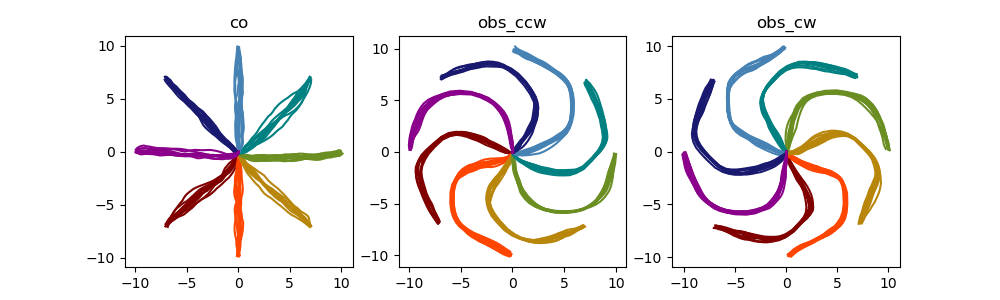

In [57]:
#Plot cw vs ccw trials, to confirm: 
m = 'n_do'
plot = {}
plot['size'] = (10,3)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

df_lqr = df_lqr_n

num_trials_plot = 10
plt.figure(figsize=plot['size'])
for i,task in enumerate(task_rot_list): 
    plt.subplot(1,3,i+1)
    plt.title(task_rot_label[i])    
    for target in range(num_targets):    
        sel = (df_lqr['task_rot']==task) & (df_lqr['bin']>=0) & (df_lqr['target']==target) & (df_lqr['model'] == m)
        df_sel = df_lqr[sel]
        #------------------------------------------------------------------------------------
        #TRIALS: 
        trial_start = np.where(df_sel['bin']==0)[0]
        trial_stop = np.where(df_sel['bin_end']==0)[0]
        trial_bound = np.vstack((trial_start,trial_stop)).T
        #------------------------------------------------------------------------------------
        for bnd in trial_bound[:num_trials_plot,:]: #trial_bound[0:1,:]:
#             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
            x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
            y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
            color = target_color[target]
            plt.plot(x,y,'-',color=color)

In [321]:
#Calculate for each bin the average activity: 
#Then ... for each model, calc command_move_mean - move_mean. 
#to start, we ask if pooling already shows a difference.

#command mean: diff, ang, mag, model
df_mean_col = n_list + ['ba', 'bm', 'model', 'num']
nan_df = pd.DataFrame()
df_mean = []

sel_bin = df_lqr['bin']>=2
for ba in range(num_angle_bins):
    sel_ba = (df_lqr['u_v_angle_bin']==ba)
    for bm in range(num_mag_bins_analyze):
        sel_bm = (df_lqr['u_v_mag_bin']==bm)
        for m in model_list:
            sel_m = (df_lqr['model'] == m)
            
            
            sel = sel_ba&sel_bm&sel_m&sel_bin
            n_i = df_lqr.loc[sel,n_list].mean()
            
            
            df_i = pd.DataFrame(pd.DataFrame(np.ones((1,len(df_mean_col)))*np.nan, columns=df_mean_col))
            df_i.loc[0,n_list]=n_i
            df_i['ba'] = ba
            df_i['bm'] = bm
            df_i['model'] = m
            df_i['num'] = len(np.where(sel)[0])
            df_mean.append(df_i)
df_mean = pd.concat(df_mean, ignore_index=True)        

                      

In [322]:
#mean diff: 
df_diff_col = n_list + ['diff', 'diff_null', 'diff_potent', 'ba', 'bm', 'model', 'target', 'task_rot', 'num']
nan_df = pd.DataFrame()
df_diff = []
for ba in range(num_angle_bins):
    sel_ba = (df_lqr['u_v_angle_bin']==ba)
    sel_d_ba = (df_mean['ba'] == ba)    
    for bm in range(num_mag_bins_analyze):
        sel_bm = (df_lqr['u_v_mag_bin']==bm)
        sel_d_bm = (df_mean['bm'] == bm)
        for m in model_list:
            sel_m = (df_lqr['model'] == m)
            sel_d_m = (df_mean['model'] == m)
            sel_d = sel_d_ba&sel_d_bm&sel_d_m
            mean_i = df_mean.loc[sel_d, n_list]
            
            
            for task in task_rot_list:
                sel_task = (df_lqr['task_rot']==task)
                for target in range(num_targets):
                    sel_target = (df_lqr['target']==target)
                    
                    sel = sel_ba&sel_bm&sel_m&sel_task&sel_target
                    num = len(np.where(sel)[0])
                    if num > 0:
                        n_i = df_lqr.loc[sel,n_list].mean()
                        diff_i = n_i-mean_i
                        diff_potent_i, diff_null_i, _ = bmi_util.proj_null_potent(Kn[2:4,:].T, np.array(diff_i).reshape((-1,1)))
                        
                        df_i = pd.DataFrame(pd.DataFrame(np.ones((1,len(df_diff_col)))*np.nan, columns=df_diff_col))
                        df_i.loc[0,n_list]=n_i
                        df_i['diff']=np.linalg.norm(diff_i)
                        df_i['diff_null']=np.linalg.norm(diff_null_i)
                        df_i['diff_potent']=np.linalg.norm(diff_potent_i)
                        df_i['ba'] = ba
                        df_i['bm'] = bm
                        df_i['model'] = m
                        df_i['task_rot'] = task
                        df_i['target'] = target
                        df_i['num'] = num

                        df_diff.append(df_i)
df_diff = pd.concat(df_diff, ignore_index=True)   

In [303]:
model_list

['n_do', 'n_null', 'n_o', 'n_d']

<IPython.core.display.Javascript object>


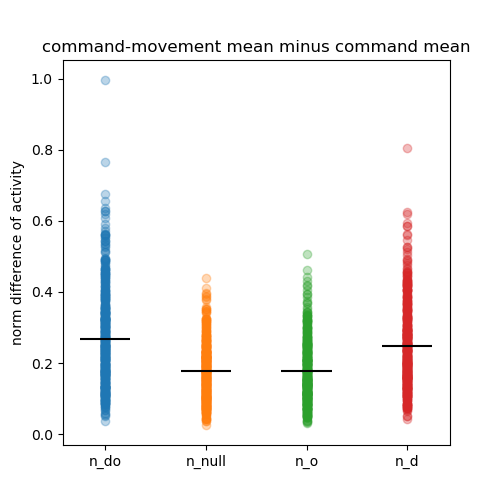

Text(0,0.5,'norm difference of activity')

In [325]:

plt.figure(figsize=(5,5))

min_obs = 5
for i,m in enumerate(model_list):
    sel_m = df_diff['model']==m
    sel_obs = df_diff['num']>=min_obs
    
    
    sel = sel_m&sel_obs
#     sel = sel_m&sel_obs
    diff_i = df_diff.loc[sel, 'diff']
    diff_mean_i = df_diff.loc[sel, 'diff'].mean()
#     num = df_diff.loc[sel, 'num'].mean()
#     print(m, test, num)
    plt.scatter(i*np.ones(len(diff_i)), diff_i, alpha=0.3)
    plt.hlines(diff_mean_i, i-0.25,i+0.25)
    
_=plt.xticks(range(len(model_list)), model_list)
plt.title('command-movement mean minus command mean')
plt.ylabel('norm difference of activity')
    

In [287]:
model_list

['n_do', 'n_null', 'n_o', 'n_d']

In [ ]:
# norm_u_df_n
# model_compare = ['n_do', 'n_o']

In [327]:
norm_u_df_n.head()

,norm_u,target,task,model
0,4.092976,0,0.0,n_do
1,2.049575,0,0.0,n_null
2,4.347140,0,0.0,n_o
3,1.551051,0,0.0,n_d
4,4.558428,0,1.1,n_do


In [328]:
task_rot_list

[0, 1.1, 1.2]

In [ ]:
def analyze_u_norm(df, model_pair, target_list, task_rot_list):
    r_u = {}
    for m in model_list:
        r_u[m]=[]
        
    for target in range(num_targets):
        for task in task_rot_list:
            for i,m in enumerate(model_pair):
                x_plot.append(i)
                sel = \
                (df['target']==target)\
                &(df['task']==task)\
                &(df['model']==m)
                y_i = float(df.loc[sel,'norm_u'])
                r_u[m].append(y_i)  
    #Stats: 
    r_wilcoxon = scipy.stats.wilcoxon(u_m[model_pair[0]], u_m[model_pair[1]])
    return r_u, r_wilcoxon

<IPython.core.display.Javascript object>


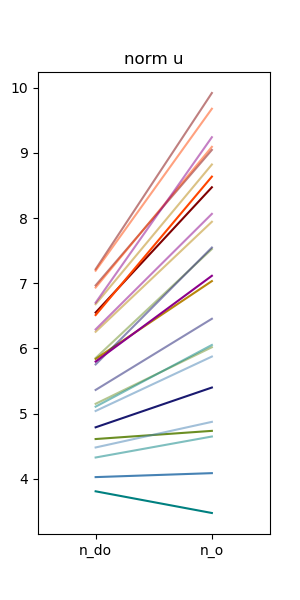

In [324]:
plot_norm_u(norm_u_df_n, ['n_do', 'n_o'], target_list, task_rot_list)

<IPython.core.display.Javascript object>


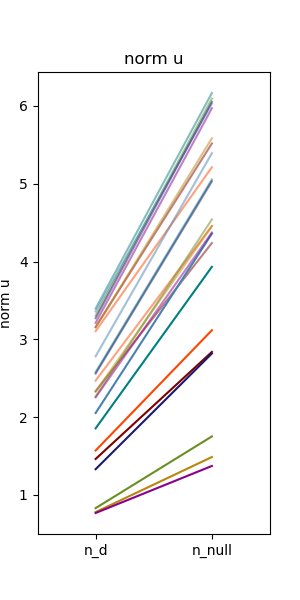

In [289]:
plot_norm_u(norm_u_df, ['n_d', 'n_null'], target_list, task_rot_list)

<IPython.core.display.Javascript object>


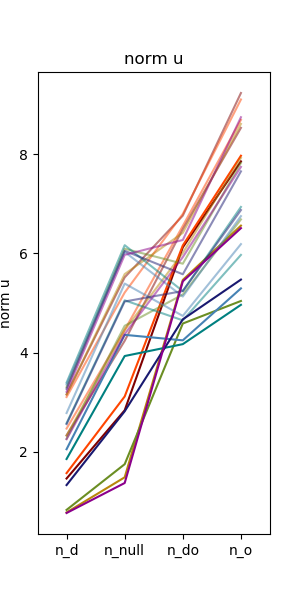

In [290]:
plot_norm_u(norm_u_df, ['n_d', 'n_null', 'n_do', 'n_o'], target_list, task_rot_list)

In [137]:
model_list

['n_do', 'n_null']

<IPython.core.display.Javascript object>


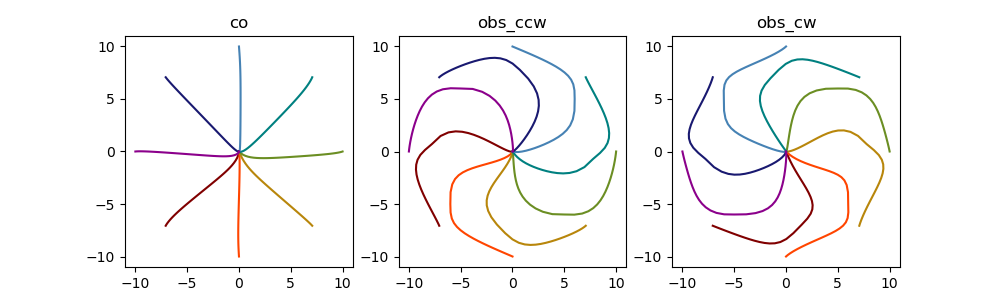

In [136]:
#Plot cw vs ccw trials, to confirm: 
m = 'n_do'
plot = {}
plot['size'] = (10,3)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']


plt.figure(figsize=plot['size'])
for i,task in enumerate(task_rot_list): 
    plt.subplot(1,3,i+1)
    plt.title(task_rot_label[i])    
    for target in range(num_targets):    
        sel = (df_lqr['task_rot']==task) & (df_lqr['bin']>=0) & (df_lqr['target']==target) & (df_lqr['model'] == m)
        df_sel = df_lqr[sel]
        #------------------------------------------------------------------------------------
        #TRIALS: 
        trial_start = np.where(df_sel['bin']==0)[0]
        trial_stop = np.where(df_sel['bin_end']==0)[0]
        trial_bound = np.vstack((trial_start,trial_stop)).T
        #------------------------------------------------------------------------------------
        for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
#             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
            x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
            y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
            color = target_color[target]
            plt.plot(x,y,'-',color=color)

In [ ]:
# TO DO: analysis

In [133]:
move_horizon

39

In [131]:
 move_lqr[0,0,'n_do']['move_len']

39

In [132]:
 move_lqr[0,1.1,'n_do']['move_len']

39

In [126]:
move_lqr[0,1.1,'n_do'].keys()

['A',
 'Q_f',
 'sim_len',
 'B',
 'K_list',
 'move_len',
 'u_da',
 'Q',
 'state_e_da',
 'R',
 'state_T_list',
 'state_init',
 'state_da',
 'horizon_list',
 'A_e_list']

In [128]:
move_lqr[0,1.1,'n_do']['state_da'].shape

(49L, 39L)

In [129]:
move_lqr[0,0,'n_do']['state_da'].shape

(49L, 39L)

In [123]:
move_lqr[0,0,'n_do']['sim_len']

32

In [120]:
move_lqr.keys()

[(7, 1.1, 'n_do'),
 (0, 1.1, 'n_do'),
 (7, 0, 'n_null'),
 (3, 0, 'n_null'),
 (5, 1.1, 'n_do'),
 (3, 1.2, 'n_do'),
 (0, 1.1, 'n_null'),
 (4, 1.2, 'n_null'),
 (3, 1.2, 'n_null'),
 (2, 1.2, 'n_null'),
 (1, 1.2, 'n_null'),
 (4, 1.2, 'n_do'),
 (6, 0, 'n_null'),
 (5, 1.2, 'n_do'),
 (2, 1.1, 'n_null'),
 (1, 1.1, 'n_null'),
 (7, 1.2, 'n_do'),
 (6, 1.1, 'n_do'),
 (2, 0, 'n_null'),
 (4, 1.1, 'n_do'),
 (5, 0, 'n_do'),
 (4, 0, 'n_null'),
 (2, 1.2, 'n_do'),
 (4, 0, 'n_do'),
 (4, 1.1, 'n_null'),
 (0, 0, 'n_null'),
 (6, 1.2, 'n_null'),
 (5, 1.2, 'n_null'),
 (3, 1.1, 'n_null'),
 (7, 0, 'n_do'),
 (0, 0, 'n_do'),
 (6, 1.1, 'n_null'),
 (1, 0, 'n_do'),
 (3, 1.1, 'n_do'),
 (6, 0, 'n_do'),
 (1, 1.1, 'n_do'),
 (7, 1.1, 'n_null'),
 (5, 1.1, 'n_null'),
 (2, 0, 'n_do'),
 (1, 1.2, 'n_do'),
 (0, 1.2, 'n_null'),
 (3, 0, 'n_do'),
 (7, 1.2, 'n_null'),
 (6, 1.2, 'n_do'),
 (5, 0, 'n_null'),
 (2, 1.1, 'n_do'),
 (0, 1.2, 'n_do'),
 (1, 0, 'n_null')]

In [119]:
df_lqr_noiseless.shape

(1872, 103)

In [117]:
39*24

936

<IPython.core.display.Javascript object>


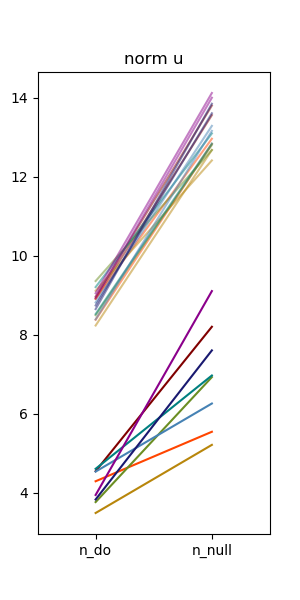

In [106]:
#Plot norm u for all movements: 
plot_norm_u(norm_u_df, model_list, target_list, task_rot_list)

In [42]:
for a in ['grom']:# a_list: #
    for d in [0]:
        t_iter_start = timeit.default_timer()
        print(a,d)
        load_dir = os.path.join(save_home, a, str(d))
#         print(os.path.exists(load_dir))
        load_file = 'lqr_sim_20trials.pkl'
        load_path = os.path.join(load_dir, load_file)
        with open(load_path, 'rb') as f: 
            r = pickle.load(f)            
        for (k,v) in r.items():
            exec(k+'=v')       

('grom', 0)


In [45]:
r.keys()

['state_dim',
 'num_neurons',
 'Qv_s',
 'norm_u_df_nl',
 'noise_dic',
 'num_offset',
 'A_dic',
 'num_trials',
 'input_label',
 'obs_margin',
 'Qfp_s',
 'Q_f',
 'state_label',
 'move_lqr_nl',
 'kin_var',
 'num_kin',
 'Qfv_s',
 'bn_m',
 'df_lqr_nl',
 'df_lqr_n',
 'B',
 'task_rot_list',
 'F',
 'n_init_dic',
 'R_s',
 'Kn',
 'Q',
 'target_list',
 'R',
 'offset_var',
 'waypoint_speed',
 'An_m',
 'A_list',
 'center',
 'model_list',
 'move_lqr_n',
 'norm_u_df_n',
 'Qp_s',
 'm_noise',
 'n_list',
 'move_horizon']

In [48]:
move_lqr=move_lqr_nl

<IPython.core.display.Javascript object>


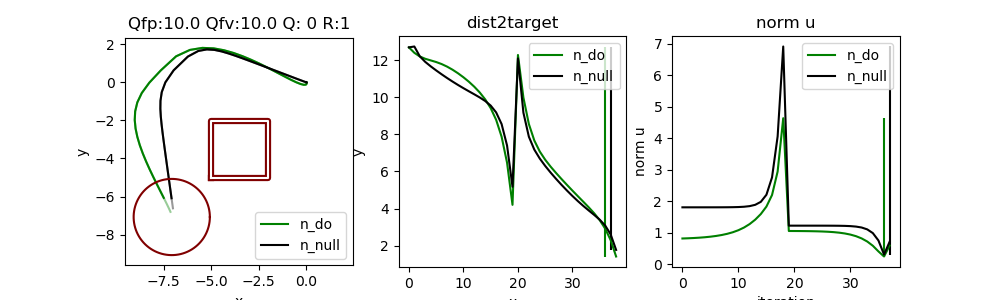

In [58]:
#SHOW ONE EXAMPLE TRIAL DIAGNOSTICS: 

#Plot each on the same subplot
#Visualize results: 
m = 'n_do'
target = 0
task = 1.1  #1.1 #1.2
horizon_list = move_lqr[target,task,m]['horizon_list']


#hardcoded:
if task >0:
    num_seg = 2
else:
    num_seg = 1    
if task == 0: 
    seg_x = np.array([[0], [horizon_list[0]]])
else:
    seg_x = np.array([[0, horizon_list[0]], [horizon_list[0]-1, sum(horizon_list)-2]])

state_T_list = move_lqr[target,task,m]['state_T_list']
state_T_mat = np.array(state_T_list).squeeze().T
if task==0:
    state_T_mat = state_T_mat.reshape((-1,1))
state_T_da = xr.DataArray(state_T_mat, coords={'v':n_list+kin_var+offset_var, 'seg':range(num_seg)},\
                           dims=['v', 'seg'])    
    


model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}

# model_list = ['n_do', 'n_o', 'n_null']
model_list = ['n_do', 'n_null']
plt.figure(figsize=(10,3))
#------------------------------------------------------------------
#CURSOR PLOTS:
plt.subplot(1,3,1)
for i,m in enumerate(model_list): #enumerate(task_models[task]):
    state_da = move_lqr[target,task,m]['state_da']
    sim_len = move_lqr[target,task,m]['sim_len']
    
    
    x = state_da.loc['kin_px',:]
    y = state_da.loc['kin_py',:]        
    plt.plot(x,y,'-', alpha=0.4, color=model_color[m]) # label=k
    
    x = state_da.loc['kin_px',np.arange(0,sim_len)]
    y = state_da.loc['kin_py',np.arange(0,sim_len)]
    plt.plot(x,y,'-', label=m, color=model_color[m])

bmi_util.plot_targets(target_pos[target:target+1,:], target_color[target:target+1], target_r_task[1]*np.ones(1)) 
c = target_color[target]
bmi_util.plot_obstacles(obs_pos[target,:].reshape((1,-1)), [c], obs_big*np.ones(1))
plt.axis('square')    
plt.xlabel('x')
plt.ylabel('y')
plt.title(m)
plt.legend()
plt.title('Qfp:' + str(Qfp_s) + ' Qfv:' + str(Qfv_s) + ' Q: ' + str(Qp_s) + ' R:' + str(R_s))  

#------------------------------------------------------------------
#Dist2Target PLOTS:
#Let's modify this to subtract the segment's goal, to verify targets are being met.

    
plt.subplot(1,3,2)
for i,m in enumerate(model_list): #for i,m in enumerate(task_models[task]):       
#     e_da = move_lqr[target,task,m]['state_e_da'].loc[['kin_px', 'kin_py'],:]
    e_a = \
        move_lqr[target,task,m]['state_da'].loc[kin_var,:]
    for seg in range(num_seg):
        e_a.loc[:,seg_x[0,seg]:seg_x[1,seg]] = e_a.loc[:,seg_x[0,seg]:seg_x[1,seg]] - \
            state_T_da.loc[kin_var,seg]
    norm_e_a = np.linalg.norm(e_a,axis=0)
    
    sim_len = move_lqr[target,task,m]['sim_len']
    norm_e = np.linalg.norm(e_a,axis=0)
    plt.plot(norm_e_a,'-',label=m, color=model_color[m])
    plt.vlines(sim_len, norm_e_a.min(), norm_e_a.max(), color=model_color[m]) #label=k+' done!'

plt.xlabel('x')
plt.ylabel('y')
plt.title(m)
plt.legend()
plt.title('dist2target')     

#------------------------------------------------------------------
#INPUT PLOTS:
plt.subplot(1,3,3)
# for i,m in enumerate(task_models[task]):
for i,m in enumerate(model_list):    
    u_da = move_lqr[target,task,m]['u_da']    
    sim_len = move_lqr[target,task,m]['sim_len']
    norm_u = np.linalg.norm(u_da,axis=0)
    plt.plot(norm_u,'-',label=m, color=model_color[m])
    plt.vlines(sim_len, norm_u.min(), norm_u.max(), color=model_color[m]) #label=k+' done!'
plt.xlabel('iteration')
plt.ylabel('norm u')
plt.title('norm u')
plt.legend()



In [52]:
for a in ['grom']:# a_list: #
    for d in [0]:
        t_iter_start = timeit.default_timer()
        print(a,d)
        load_dir = os.path.join(save_home, a, str(d))
#         print(os.path.exists(load_dir))
        load_file = 'lqr_sim_20trials_dlqr_change.pkl'
        load_path = os.path.join(load_dir, load_file)
        with open(load_path, 'rb') as f: 
            r = pickle.load(f)            
        for (k,v) in r.items():
            exec(k+'=v')   
move_lqr = move_lqr_nl

('grom', 0)


<IPython.core.display.Javascript object>


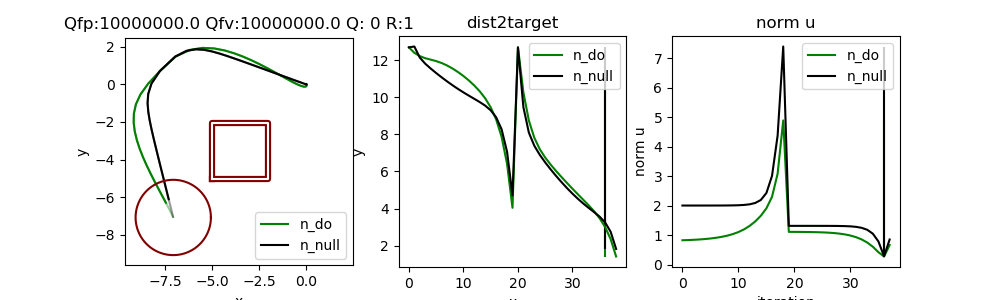

In [53]:
#SHOW ONE EXAMPLE TRIAL DIAGNOSTICS: 

#Plot each on the same subplot
#Visualize results: 
m = 'n_do'
target = 0
task = 1.1  #1.1 #1.2
horizon_list = move_lqr[target,task,m]['horizon_list']


#hardcoded:
if task >0:
    num_seg = 2
else:
    num_seg = 1    
if task == 0: 
    seg_x = np.array([[0], [horizon_list[0]]])
else:
    seg_x = np.array([[0, horizon_list[0]], [horizon_list[0]-1, sum(horizon_list)-2]])

state_T_list = move_lqr[target,task,m]['state_T_list']
state_T_mat = np.array(state_T_list).squeeze().T
if task==0:
    state_T_mat = state_T_mat.reshape((-1,1))
state_T_da = xr.DataArray(state_T_mat, coords={'v':n_list+kin_var+offset_var, 'seg':range(num_seg)},\
                           dims=['v', 'seg'])    
    


model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}

# model_list = ['n_do', 'n_o', 'n_null']
model_list = ['n_do', 'n_null']
plt.figure(figsize=(10,3))
#------------------------------------------------------------------
#CURSOR PLOTS:
plt.subplot(1,3,1)
for i,m in enumerate(model_list): #enumerate(task_models[task]):
    state_da = move_lqr[target,task,m]['state_da']
    sim_len = move_lqr[target,task,m]['sim_len']
    
    
    x = state_da.loc['kin_px',:]
    y = state_da.loc['kin_py',:]        
    plt.plot(x,y,'-', alpha=0.4, color=model_color[m]) # label=k
    
    x = state_da.loc['kin_px',np.arange(0,sim_len)]
    y = state_da.loc['kin_py',np.arange(0,sim_len)]
    plt.plot(x,y,'-', label=m, color=model_color[m])

bmi_util.plot_targets(target_pos[target:target+1,:], target_color[target:target+1], target_r_task[1]*np.ones(1)) 
c = target_color[target]
bmi_util.plot_obstacles(obs_pos[target,:].reshape((1,-1)), [c], obs_big*np.ones(1))
plt.axis('square')    
plt.xlabel('x')
plt.ylabel('y')
plt.title(m)
plt.legend()
plt.title('Qfp:' + str(Qfp_s) + ' Qfv:' + str(Qfv_s) + ' Q: ' + str(Qp_s) + ' R:' + str(R_s))  

#------------------------------------------------------------------
#Dist2Target PLOTS:
#Let's modify this to subtract the segment's goal, to verify targets are being met.

    
plt.subplot(1,3,2)
for i,m in enumerate(model_list): #for i,m in enumerate(task_models[task]):       
#     e_da = move_lqr[target,task,m]['state_e_da'].loc[['kin_px', 'kin_py'],:]
    e_a = \
        move_lqr[target,task,m]['state_da'].loc[kin_var,:]
    for seg in range(num_seg):
        e_a.loc[:,seg_x[0,seg]:seg_x[1,seg]] = e_a.loc[:,seg_x[0,seg]:seg_x[1,seg]] - \
            state_T_da.loc[kin_var,seg]
    norm_e_a = np.linalg.norm(e_a,axis=0)
    
    sim_len = move_lqr[target,task,m]['sim_len']
    norm_e = np.linalg.norm(e_a,axis=0)
    plt.plot(norm_e_a,'-',label=m, color=model_color[m])
    plt.vlines(sim_len, norm_e_a.min(), norm_e_a.max(), color=model_color[m]) #label=k+' done!'

plt.xlabel('x')
plt.ylabel('y')
plt.title(m)
plt.legend()
plt.title('dist2target')     

#------------------------------------------------------------------
#INPUT PLOTS:
plt.subplot(1,3,3)
# for i,m in enumerate(task_models[task]):
for i,m in enumerate(model_list):    
    u_da = move_lqr[target,task,m]['u_da']    
    sim_len = move_lqr[target,task,m]['sim_len']
    norm_u = np.linalg.norm(u_da,axis=0)
    plt.plot(norm_u,'-',label=m, color=model_color[m])
    plt.vlines(sim_len, norm_u.min(), norm_u.max(), color=model_color[m]) #label=k+' done!'
plt.xlabel('iteration')
plt.ylabel('norm u')
plt.title('norm u')
plt.legend()



In [87]:
move_lqr[0,0,'n_do'].keys()

['A',
 'Q_f',
 'sim_len',
 'B',
 'K_list',
 'move_len',
 'u_da',
 'Q',
 'state_e_da',
 'R',
 'state_T_list',
 'state_init',
 'state_da',
 'horizon_list',
 'A_e_list']

In [94]:
move_lqr[0,0,'n_do']['state_da'].shape

(49L, 39L)

In [85]:
move_lqr.keys()

[(7, 1.1, 'n_do'),
 (0, 1.1, 'n_do'),
 (7, 0, 'n_null'),
 (3, 0, 'n_null'),
 (5, 1.1, 'n_do'),
 (3, 1.2, 'n_do'),
 (0, 1.1, 'n_null'),
 (4, 1.2, 'n_null'),
 (3, 1.2, 'n_null'),
 (2, 1.2, 'n_null'),
 (1, 1.2, 'n_null'),
 (4, 1.2, 'n_do'),
 (6, 0, 'n_null'),
 (5, 1.2, 'n_do'),
 (2, 1.1, 'n_null'),
 (1, 1.1, 'n_null'),
 (7, 1.2, 'n_do'),
 (6, 1.1, 'n_do'),
 (2, 0, 'n_null'),
 (4, 1.1, 'n_do'),
 (5, 0, 'n_do'),
 (4, 0, 'n_null'),
 (2, 1.2, 'n_do'),
 (4, 0, 'n_do'),
 (4, 1.1, 'n_null'),
 (0, 0, 'n_null'),
 (6, 1.2, 'n_null'),
 (5, 1.2, 'n_null'),
 (3, 1.1, 'n_null'),
 (7, 0, 'n_do'),
 (0, 0, 'n_do'),
 (6, 1.1, 'n_null'),
 (1, 0, 'n_do'),
 (3, 1.1, 'n_do'),
 (6, 0, 'n_do'),
 (1, 1.1, 'n_do'),
 (7, 1.1, 'n_null'),
 (5, 1.1, 'n_null'),
 (2, 0, 'n_do'),
 (1, 1.2, 'n_do'),
 (0, 1.2, 'n_null'),
 (3, 0, 'n_do'),
 (7, 1.2, 'n_null'),
 (6, 1.2, 'n_do'),
 (5, 0, 'n_null'),
 (2, 1.1, 'n_do'),
 (0, 1.2, 'n_do'),
 (1, 0, 'n_null')]

In [73]:
move_lqr.keys()

[(7, 1.1, 'n_do'),
 (0, 1.1, 'n_do'),
 (7, 0, 'n_null'),
 (3, 0, 'n_null'),
 (5, 1.1, 'n_do'),
 (3, 1.2, 'n_do'),
 (0, 1.1, 'n_null'),
 (4, 1.2, 'n_null'),
 (3, 1.2, 'n_null'),
 (2, 1.2, 'n_null'),
 (1, 1.2, 'n_null'),
 (4, 1.2, 'n_do'),
 (6, 0, 'n_null'),
 (5, 1.2, 'n_do'),
 (2, 1.1, 'n_null'),
 (1, 1.1, 'n_null'),
 (7, 1.2, 'n_do'),
 (6, 1.1, 'n_do'),
 (2, 0, 'n_null'),
 (4, 1.1, 'n_do'),
 (5, 0, 'n_do'),
 (4, 0, 'n_null'),
 (2, 1.2, 'n_do'),
 (4, 0, 'n_do'),
 (4, 1.1, 'n_null'),
 (0, 0, 'n_null'),
 (6, 1.2, 'n_null'),
 (5, 1.2, 'n_null'),
 (3, 1.1, 'n_null'),
 (7, 0, 'n_do'),
 (0, 0, 'n_do'),
 (6, 1.1, 'n_null'),
 (1, 0, 'n_do'),
 (3, 1.1, 'n_do'),
 (6, 0, 'n_do'),
 (1, 1.1, 'n_do'),
 (7, 1.1, 'n_null'),
 (5, 1.1, 'n_null'),
 (2, 0, 'n_do'),
 (1, 1.2, 'n_do'),
 (0, 1.2, 'n_null'),
 (3, 0, 'n_do'),
 (7, 1.2, 'n_null'),
 (6, 1.2, 'n_do'),
 (5, 0, 'n_null'),
 (2, 1.1, 'n_do'),
 (0, 1.2, 'n_do'),
 (1, 0, 'n_null')]

In [68]:
A_dic.keys()

['n_null', 'n_do', 'n_o']

In [50]:
bn_m.shape

(44L, 1L)

In [ ]:
#Define Models for each movement
#For each movement:
#Define number of segments, number of 
n_list = ['n_'+str(i) for i in range(num_neurons)]

move_horizon = 39
model_list = ['n_do', 'n_null'] #'n_o',
input_label = n_list

target_list = range(num_targets)
task_rot_list = [0,1.1,1.2]
center = np.array([0,0])
#waypoint parameters:
obs_margin = 6
waypoint_speed = 10

#This does movement simulation too!  
n_init_sel = np.zeros(len(n_init)) #n_init

num_trials = 1000
t_start = timeit.default_timer()
move_lqr = bmi_b.sim_lqr_move_noise(\
    num_trials, move_horizon, model_list, A_dic, B, Q, R, Q_f, noise_dic,\
    target_list, task_rot_list, center, target_pos, obs_pos, n_init_sel, obs_margin, waypoint_speed,\
    state_label, state_dim, input_label, num_neurons, hold_req=2, target_r=1.7)
t_elapsed = timeit.default_timer()-t_start
print(t_elapsed)
